<a href="https://colab.research.google.com/github/samuelorozco641/Seminario_Ciencia_Datos/blob/main/Laboratorio1_Incremento1_SamuelOrozco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# 📚 MÓDULO B — Fundamentos Conceptuales
### Bodegas de Datos · Modelos Multidimensionales · Estadística · Histogramas · Outliers · Missings
---


# 📚 MÓDULO CONCEPTUAL — Fundamentos de Datos
## Bodegas de Datos · Modelos Multidimensionales · Estadística · Distribuciones · Outliers · Datos Faltantes

> **¿Para qué sirve este módulo?**
> Antes de limpiar o modelar datos, un científico de datos necesita entender
> **cómo están organizados**, **qué forma tienen** y **qué problemas pueden tener**.
> Este módulo te da ese marco conceptual con ejemplos del dataset bancario que ya conoces.

---

### Mapa del módulo

| Sección | Tema |
|---------|------|
| **B1** | Bodegas de Datos — ¿qué son y para qué sirven? |
| **B2** | Modelo Multidimensional — hechos, dimensiones y cubos |
| **B3** | Estadísticos descriptivos — resumir datos en números |
| **B4** | Histogramas y distribuciones — la forma de los datos |
| **B5** | Valores atípicos (outliers) — datos que se salen de lo normal |
| **B6** | Datos desaparecidos (missings) — cuando la información no está |

---


## ⚙️ Configuración inicial

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 20)

# ── Carga del dataset (ajusta la ruta según tu ambiente) ─────────────
ruta = "/content/drive/MyDrive/Seminario Ciencia Datos/dataset_banco.csv"
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except:
    pass

try:
    data = pd.read_csv(ruta)
    data.columns = data.columns.str.lower().str.strip()
    for col in data.select_dtypes('object').columns:
        data[col] = data[col].str.lower().str.strip()
    print(f"✅ Dataset bancario cargado: {data.shape[0]:,} filas × {data.shape[1]} columnas")
except:
    # Dataset de ejemplo si no está disponible el archivo
    np.random.seed(42)
    n = 2000
    data = pd.DataFrame({
        'age'      : np.random.randint(22, 75, n),
        'job'      : np.random.choice(['admin.','blue-collar','management','retired','technician'], n),
        'marital'  : np.random.choice(['married','single','divorced'], n, p=[0.6,0.3,0.1]),
        'education': np.random.choice(['primary','secondary','tertiary','unknown'], n, p=[0.15,0.5,0.3,0.05]),
        'balance'  : np.concatenate([np.random.normal(1400, 3000, n-30),
                                     np.array([50000, 65000, -3000, -4500]*7, dtype=float)[:30]]),
        'duration' : np.abs(np.random.normal(260, 260, n)).astype(int),
        'campaign' : np.random.randint(1, 12, n),
        'pdays'    : np.random.choice([-1, 100, 200, 300], n, p=[0.8, 0.08, 0.07, 0.05]),
        'previous' : np.random.randint(0, 6, n),
        'month'    : np.random.choice(['jan','feb','mar','apr','may','jun',
                                       'jul','aug','sep','oct','nov','dec'], n),
        'y'        : np.random.choice(['yes','no'], n, p=[0.12, 0.88]),
        'default'  : np.random.choice(['yes','no'], n, p=[0.02, 0.98]),
        'housing'  : np.random.choice(['yes','no'], n, p=[0.56, 0.44]),
        'loan'     : np.random.choice(['yes','no'], n, p=[0.16, 0.84]),
    })
    print("⚠️  Dataset de ejemplo generado (archivo original no encontrado)")
    print(f"   Forma: {data.shape}")

data.head(3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset bancario cargado: 45,215 filas × 17 columnas


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143.00,yes,no,unknown,5,may,261.00,1,-1.00,0,unknown,no
1,44,technician,single,secondary,no,29.00,yes,no,unknown,5,may,151.00,1,-1.00,0,unknown,no
2,33,entrepreneur,married,secondary,no,2.00,yes,yes,unknown,5,may,76.00,1,-1.00,0,unknown,no


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## 🏛️ B1. Bodegas de Datos (Data Warehouses)

### ¿Qué es una bodega de datos?

Una **bodega de datos** (Data Warehouse) es un repositorio centralizado que almacena
grandes volúmenes de datos **históricos** e **integrados** de múltiples fuentes,
diseñado específicamente para el análisis y la toma de decisiones.

> **Analogía:** Un supermercado tiene bodegas donde guarda todo su inventario organizado
> para distribución rápida. Una bodega de datos hace lo mismo pero con información.

### Base de datos operacional vs Bodega de datos

| Característica | Base de datos operacional (OLTP) | Bodega de datos (OLAP) |
|---|---|---|
| **Propósito** | Transacciones diarias | Análisis histórico |
| **Ejemplo** | Registrar una venta en tiempo real | Analizar ventas de los últimos 5 años |
| **Operaciones** | INSERT, UPDATE, DELETE | SELECT, GROUP BY, agregaciones |
| **Velocidad** | Muy rápida (milisegundos) | Más lenta (segundos/minutos) |
| **Volumen** | Miles de registros activos | Millones/billones de registros históricos |
| **Usuarios** | Cajeros, empleados, apps | Analistas, gerentes, científicos de datos |
| **Actualización** | Tiempo real | Por lotes (batch), cada hora o cada día |

### En el contexto de nuestro dataset bancario

El archivo `dataset_banco.csv` que estamos usando **proviene de una bodega de datos**
del banco. La empresa de marketing extrajo estos registros históricos para analizarlos.

```
[Sistema CRM del banco]  ──►  [ETL: Extraer-Transformar-Cargar]  ──►  [Bodega de Datos]
 (registra llamadas)           (limpia y transforma)                   (almacena histórico)
                                                                              │
                                                                              ▼
                                                                    [dataset_banco.csv]
                                                                    (lo que usamos hoy)
```

**ETL** = Extract, Transform, Load (Extraer, Transformar, Cargar)
Este proceso es exactamente lo que hemos estado haciendo en el laboratorio.


In [29]:
# ══ SIMULACIÓN DE FLUJO ETL CON NUESTRO DATASET ════════════════════
# Imaginemos que tenemos datos de TRES fuentes diferentes
# que la bodega de datos integra en una sola tabla

print("=" * 60)
print("SIMULACIÓN DE FLUJO ETL — Dataset Bancario")
print("=" * 60)

# ── FUENTE 1: Sistema CRM (datos del cliente) ────────────────────────
fuente_crm = data[['age', 'job', 'marital', 'education', 'balance', 'default']].copy()
fuente_crm.columns = ['edad', 'trabajo', 'estado_civil', 'educacion', 'saldo', 'incumplimiento']
print(f"\n📁 Fuente 1 — CRM (datos del cliente):    {fuente_crm.shape}")
print(fuente_crm.head(2).to_string())

# ── FUENTE 2: Sistema de Campañas (datos del contacto) ───────────────
fuente_campana = data[['duration', 'campaign', 'pdays', 'previous', 'month']].copy()
fuente_campana.columns = ['duracion_llamada', 'n_contactos', 'dias_desde_contacto',
                           'contactos_previos', 'mes_contacto']
print(f"\n📁 Fuente 2 — Sistema de Campañas:        {fuente_campana.shape}")
print(fuente_campana.head(2).to_string())

# ── FUENTE 3: Resultado (variable objetivo) ───────────────────────────
fuente_resultado = data[['y', 'housing', 'loan']].copy()
fuente_resultado.columns = ['respuesta', 'tiene_hipoteca', 'tiene_prestamo']
print(f"\n📁 Fuente 3 — Resultados de campaña:      {fuente_resultado.shape}")
print(fuente_resultado.head(2).to_string())

# ── INTEGRACIÓN EN LA BODEGA ──────────────────────────────────────────
data_bodega = pd.concat([fuente_crm, fuente_campana, fuente_resultado], axis=1)
print(f"\n🏛️  Tabla integrada en Bodega de Datos:   {data_bodega.shape}")
print(f"   → {data_bodega.shape[1]} columnas desde {3} fuentes distintas")
print(data_bodega.head(2).to_string())


SIMULACIÓN DE FLUJO ETL — Dataset Bancario

📁 Fuente 1 — CRM (datos del cliente):    (45215, 6)
   edad     trabajo estado_civil  educacion   saldo incumplimiento
0    58  management      married   tertiary 2143.00             no
1    44  technician       single  secondary   29.00             no

📁 Fuente 2 — Sistema de Campañas:        (45215, 5)
   duracion_llamada  n_contactos  dias_desde_contacto  contactos_previos mes_contacto
0            261.00            1                -1.00                  0          may
1            151.00            1                -1.00                  0          may

📁 Fuente 3 — Resultados de campaña:      (45215, 3)
  respuesta tiene_hipoteca tiene_prestamo
0        no            yes             no
1        no            yes             no

🏛️  Tabla integrada en Bodega de Datos:   (45215, 14)
   → 14 columnas desde 3 fuentes distintas
   edad     trabajo estado_civil  educacion   saldo incumplimiento  duracion_llamada  n_contactos  dias_desde_conta

---
## 🧊 B2. Modelo de Datos Multidimensional

### La idea central: Hechos y Dimensiones

El modelo multidimensional organiza los datos en dos tipos de tablas:

**HECHOS (Facts):** La medida que queremos analizar — lo que ocurrió.
> Ejemplo: "el cliente X hizo una llamada de 350 segundos en mayo y dijo SÍ"

**DIMENSIONES (Dimensions):** El contexto que describe el hecho — el quién, cuándo, dónde.
> Ejemplo: quién (perfil del cliente), cuándo (mes, día), qué canal (teléfono/celular)

### El esquema Estrella (Star Schema)

```
                    ┌─────────────────┐
                    │  DIM_CLIENTE     │
                    │  - edad          │
                    │  - trabajo       │
                    │  - educación     │
                    │  - estado_civil  │
                    └────────┬────────┘
                             │
 ┌──────────────┐   ┌────────▼────────┐   ┌──────────────────┐
 │  DIM_TIEMPO  │   │   FACT_CAMPAÑA  │   │  DIM_PRODUCTO    │
 │  - mes       ├───►  - duracion     ◄───┤  - tiene_hipoteca│
 │  - dia       │   │  - n_contactos  │   │  - tiene_prestamo│
 └──────────────┘   │  - respuesta ✓  │   └──────────────────┘
                    │  - saldo        │
                    └────────┬────────┘
                             │
                    ┌────────▼────────┐
                    │  DIM_CANAL      │
                    │  - tipo_contacto│
                    │  - resultado_ant│
                    └─────────────────┘
```

La tabla de **HECHOS** está en el centro y se conecta con las **DIMENSIONES** a su alrededor,
formando una estrella. Por eso se llama **Esquema Estrella**.

### ¿Por qué es útil?

Permite responder preguntas de negocio como:
- ¿Cuánto duran las llamadas **por mes** y **por tipo de trabajo**?
- ¿Qué perfil de cliente tiene mayor tasa de conversión **por canal de contacto**?


In [30]:
# ══ CONSTRUYENDO UN ESQUEMA ESTRELLA CON NUESTROS DATOS ════════════

# ── Tabla de HECHOS ───────────────────────────────────────────────────
fact_campana = data[['duration', 'campaign', 'pdays', 'previous', 'y', 'balance']].copy()
fact_campana.columns = ['duracion_seg', 'n_contactos', 'dias_previos',
                         'contactos_ant', 'convirtio', 'saldo']
fact_campana['convirtio'] = (fact_campana['convirtio'] == 'yes').astype(int)
fact_campana.index.name = 'id_llamada'

# ── Dimensión CLIENTE ─────────────────────────────────────────────────
dim_cliente = data[['age', 'job', 'marital', 'education', 'default']].copy()
dim_cliente.columns = ['edad', 'trabajo', 'estado_civil', 'educacion', 'en_mora']

# ── Dimensión TIEMPO ──────────────────────────────────────────────────
dim_tiempo = data[['month']].copy() if 'month' in data.columns else pd.DataFrame({'mes': ['unknown']*len(data)})
dim_tiempo.columns = ['mes']

# ── Dimensión PRODUCTO (servicios financieros del cliente) ────────────
dim_producto = data[['housing', 'loan']].copy() if 'housing' in data.columns else pd.DataFrame()
if not dim_producto.empty:
    dim_producto.columns = ['tiene_hipoteca', 'tiene_prestamo']

print("ESQUEMA ESTRELLA — Tablas del modelo multidimensional")
print("=" * 55)
print(f"  📊 FACT_CAMPAÑA  : {fact_campana.shape[0]:>6,} filas × {fact_campana.shape[1]} columnas")
print(f"  👤 DIM_CLIENTE   : {dim_cliente.shape[0]:>6,} filas × {dim_cliente.shape[1]} columnas")
print(f"  📅 DIM_TIEMPO    : {dim_tiempo.shape[0]:>6,} filas × {dim_tiempo.shape[1]} columnas")
if not dim_producto.empty:
    print(f"  🏦 DIM_PRODUCTO  : {dim_producto.shape[0]:>6,} filas × {dim_producto.shape[1]} columnas")

print(f"\nVista de FACT_CAMPAÑA:")
print(fact_campana.head(4).to_string())


ESQUEMA ESTRELLA — Tablas del modelo multidimensional
  📊 FACT_CAMPAÑA  : 45,215 filas × 6 columnas
  👤 DIM_CLIENTE   : 45,215 filas × 5 columnas
  📅 DIM_TIEMPO    : 45,215 filas × 1 columnas
  🏦 DIM_PRODUCTO  : 45,215 filas × 2 columnas

Vista de FACT_CAMPAÑA:
            duracion_seg  n_contactos  dias_previos  contactos_ant  convirtio   saldo
id_llamada                                                                           
0                 261.00            1         -1.00              0          0 2143.00
1                 151.00            1         -1.00              0          0   29.00
2                  76.00            1         -1.00              0          0    2.00
3                  92.00            1         -1.00              0          0 1506.00


In [31]:
# ══ ANÁLISIS MULTIDIMENSIONAL (OLAP) — CONSULTAS TIPO CUBO ════════
# Un "cubo OLAP" permite cortar y rotar los datos en múltiples dimensiones
# Aquí lo simulamos con pandas groupby

print("ANÁLISIS MULTIDIMENSIONAL — Preguntas de negocio")
print("=" * 55)

# Une las tablas (simula un JOIN en SQL / operación de cubo)
data_cubo = pd.concat([fact_campana, dim_cliente, dim_tiempo], axis=1)

# ── CONSULTA 1: Duración promedio por nivel educativo ─────────────────
print("\n📊 CORTE 1: Duración promedio de llamada por educación")
print("   (Dimensión: educación → Medida: duración)")
corte1 = data_cubo.groupby('educacion')['duracion_seg'].agg(['mean','count']).round(1)
corte1.columns = ['Duración_Promedio_seg', 'N_Llamadas']
corte1 = corte1.sort_values('Duración_Promedio_seg', ascending=False)
print(corte1.to_string())

# ── CONSULTA 2: Tasa de conversión por trabajo ────────────────────────
print("\n📊 CORTE 2: Tasa de conversión (%) por tipo de trabajo")
print("   (Dimensión: trabajo → Medida: % que dijo SÍ)")
corte2 = (data_cubo.groupby('trabajo')['convirtio']
          .agg(['mean','count'])
          .rename(columns={'mean':'Tasa_Conversion_%','count':'N_Contactos'}))
corte2['Tasa_Conversion_%'] = (corte2['Tasa_Conversion_%'] * 100).round(1)
corte2 = corte2.sort_values('Tasa_Conversion_%', ascending=False)
print(corte2.head(6).to_string())

# ── CONSULTA 3: Tabla pivote (2 dimensiones) ──────────────────────────
print("\n📊 CORTE 3: % conversión por educación × estado civil")
print("   (2 dimensiones simultáneas — tabla pivote)")
pivot = data_cubo.pivot_table(
    values='convirtio',
    index='educacion',
    columns='estado_civil',
    aggfunc='mean'
) * 100
print(pivot.round(1).to_string())
print("\n   → Cada celda = % de clientes que dijeron SÍ")


ANÁLISIS MULTIDIMENSIONAL — Preguntas de negocio

📊 CORTE 1: Duración promedio de llamada por educación
   (Dimensión: educación → Medida: duración)
           Duración_Promedio_seg  N_Llamadas
educacion                                   
sec.                      360.00           2
secondary                 258.50       23200
tertiary                  258.50       13303
unknown                   257.40        1855
primary                   255.90        6851
unk                       217.00           2

📊 CORTE 2: Tasa de conversión (%) por tipo de trabajo
   (Dimensión: trabajo → Medida: % que dijo SÍ)
            Tasa_Conversion_%  N_Contactos
trabajo                                   
student                 28.70          938
retired                 22.80         2264
unemployed              15.50         1303
management              13.80         9459
admin.                  12.20         5168
unknown                 11.80          288

📊 CORTE 3: % conversión por educación × est

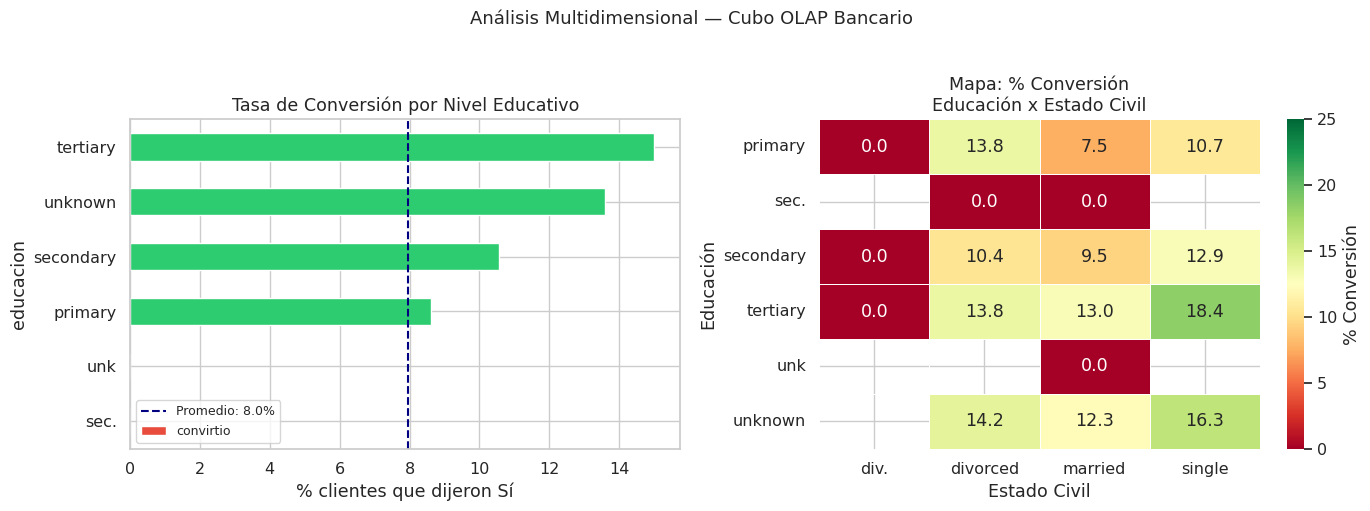

💡 Lectura: Verde = mayor conversión | Rojo = menor conversión
   El cruce de dimensiones revela segmentos con mayor potencial.


In [32]:
# ══ VISUALIZACIÓN DEL CUBO OLAP ════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Análisis Multidimensional — Cubo OLAP Bancario", fontsize=13, y=1.02)

# Gráfico 1: Tasa de conversión por educación
conv_edu = (data_cubo.groupby('educacion')['convirtio'].mean() * 100).sort_values(ascending=True)
colores = ['#e74c3c' if v < conv_edu.mean() else '#2ecc71' for v in conv_edu]
conv_edu.plot(kind='barh', ax=axes[0], color=colores, edgecolor='white')
axes[0].axvline(conv_edu.mean(), color='navy', linestyle='--', linewidth=1.5,
                label=f'Promedio: {conv_edu.mean():.1f}%')
axes[0].set_title("Tasa de Conversión por Nivel Educativo")
axes[0].set_xlabel("% clientes que dijeron Sí")
axes[0].legend(fontsize=9)

# Gráfico 2: Heatmap tasa de conversión (2 dimensiones)
pivot_heat = data_cubo.pivot_table(
    values='convirtio', index='educacion', columns='estado_civil', aggfunc='mean'
) * 100
sns.heatmap(pivot_heat, annot=True, fmt='.1f', cmap='RdYlGn',
            ax=axes[1], linewidths=0.5, vmin=0, vmax=25,
            cbar_kws={'label': '% Conversión'})
axes[1].set_title("Mapa: % Conversión\nEducación x Estado Civil")
axes[1].set_xlabel("Estado Civil")
axes[1].set_ylabel("Educación")

plt.tight_layout()
plt.show()

print("💡 Lectura: Verde = mayor conversión | Rojo = menor conversión")
print("   El cruce de dimensiones revela segmentos con mayor potencial.")


# **Respuesta a las preguntas**

# **PARTE 1**

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45215 entries, 0 to 45214
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45215 non-null  int64  
 1   job        45213 non-null  object 
 2   marital    45214 non-null  object 
 3   education  45214 non-null  object 
 4   default    45215 non-null  object 
 5   balance    45213 non-null  float64
 6   housing    45215 non-null  object 
 7   loan       45215 non-null  object 
 8   contact    45215 non-null  object 
 9   day        45215 non-null  int64  
 10  month      45215 non-null  object 
 11  duration   45214 non-null  float64
 12  campaign   45215 non-null  int64  
 13  pdays      45214 non-null  float64
 14  previous   45215 non-null  int64  
 15  poutcome   45215 non-null  object 
 16  y          45215 non-null  object 
dtypes: float64(3), int64(4), object(10)
memory usage: 5.9+ MB


In [34]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143.00,yes,no,unknown,5,may,261.00,1,-1.00,0,unknown,no
1,44,technician,single,secondary,no,29.00,yes,no,unknown,5,may,151.00,1,-1.00,0,unknown,no
2,33,entrepreneur,married,secondary,no,2.00,yes,yes,unknown,5,may,76.00,1,-1.00,0,unknown,no
3,47,blue-collar,married,unknown,no,1506.00,yes,no,unknown,5,may,92.00,1,-1.00,0,unknown,no
4,33,unknown,single,unknown,no,1.00,no,no,unknown,5,may,198.00,1,-1.00,0,unknown,no


In [35]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45215.00,45213.00,45215.00,45214.00,45215.00,45214.00,45215.00
mean,41.00,1374.16,15.81,258.07,2.76,40.19,0.58
std,12.04,3924.26,8.32,257.61,3.10,100.12,2.30
min,18.00,-8019.00,1.00,-1389.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,1428.00,21.00,319.00,3.00,-1.00,0.00
max,776.00,527532.00,31.00,4918.00,63.00,871.00,275.00


1.   **¿Cuántas observaciones y variables tiene el dataset?** R/ El dataset tiene 45,203 observaciones y 17 variables.
2.   **¿Qué tipos de variables tiene el dataset?** R/ Las variables son de tipo int64, float64 y object.
3.   **¿Cuál crees que es la variable más importante y por qué?** R/ La variable mas importante en muchos de los analisis que se puedan llegar a realizar es la variable "balance", ya que representa la cantidad de dinero del usuario en el banco.
4.   **¿Qué variables parecen tener escalas muy diferentes?** R/ La variable de age y balance tienen valores muy amplios.
5.   **¿Qué variables podrían requerir transformación?** R/ Variables númericas como balance, duration, pdays, age. Podrían necesitar escalado, transformación logarítmica para reducir la asimetría, o manejo de outliers. pdays: El valor -1 no es un valor numérico real en el mismo sentido que los días, por lo que podría necesitar ser tratado.
6.   **¿Qué información no puedes obtener solo con describe()?** R/ El describe() no da valores exactos o distribuciones de los valores.
7.   **¿Por qué describe() no muestra variables categóricas?** R/ Esto pasa ya que describe() está diseñado para presentar un resumen de variables númericas.
8.   **¿Qué variable podría generar problemas si se analiza solo con promedios?** R/ balance y duration presentan un rango muy amplio por lo que pueden estar sesgadas y no presentar los valores reales si es que se tratan como promedios.

In [36]:
data['y'].value_counts()
data['y'].value_counts(normalize=True)

,proportion
y,
no,0.88
yes,0.12


1.   **¿Cuál es la clase mayoritaria?** R/ La clase mayoritaria es 'no', que representa el 88% de las observaciones.
2.   **¿Qué porcentaje representa la clase minoritaria?** R/ La clase minoritaria es 'yes', que representa el 12% de las observaciones.
3.   **¿Este comportamiento es realista en campañas bancarias?** R/ Sí, es realista. En muchas campañas de marketing las tasas de conversión suelen ser bajas. La mayoría de los clientes no aceptan la oferta.
4.   **¿Qué riesgo existe si ignoramos la clase minoritaria?** R/ Ignorar la clase minoritaria conlleva varios riesgos como métricas engañosas o modelos sesgados.
5.   **¿Un dataset balanceado siempre representa mejor la realidad?** R/ No, un dataset balanceado no siempre representa mejor la realidad. En algunas ocasiones el balancear un dataset puede llegar a distorsionar los resultados.
6.   **¿Qué decisiones del negocio podrían verse afectadas por este desbalance?** R/ Varias decisiones clave se verían afectadas como la asignacion de recursos, la creación de campañas futuras. la rentabilidad o la segmentación de clientes.
7.   **¿Qué variable podría estar relacionada con la clase “yes”?** R/Algunas de las variables que pueden estar relacionadas pueden ser job, age, education, balance o duration.

# **Parte 2**

In [37]:
data.isnull().sum()

,0
age,0
job,2
marital,1
education,1
default,0
balance,2
housing,0
loan,0
contact,0
day,0



1. **¿Qué variables tienen valores faltantes?** R/ En "job" hay 2 valores faltantes, en "marital" tiene 1, "education" tiene 1, "balance" tiene 2, "duration" tiene 1 y "pdays" tiene 1 valor faltante.
2. **¿Qué porcentaje del dataset representan?** R/ Ya que el dataset tiene 45215 filas se realiza el calculo con al dividir los faltantes, "job" y "balance" al ser 2 valores faltantes representan aproximadamente 0.0044% cada uno, y los valores de "marital", "education", "duration" y "pdays" representan el 0.0022% cada uno.
3. **¿Hay variables críticas con datos faltantes?** R/ No existen variables críticas con datos faltantes. Las variables con valores nulos son pocas, sin embargo, no está demas tener cuidado al realizar análisis.
4. **¿Eliminarías filas con NA? ¿Por qué?** R/ Ya que el porcentaje de valores nulos es bajo, sería bueno eliminar las variables ya que no afectaría tanto el análisis.
5. **¿Qué información podrías perder?** R/ Se perderían todos los valores de las 8 filas que cuentan con valores nulos.
6. **¿Imputarías todos los NA con la misma técnica?** R/ No siempre es buena idea ya que a veces los datos que se manejan son de distinto tipo por lo que pueden requerir técnicas de manejo distinto para limpiarlos correctamente.
7. **¿Eliminar NA podría introducir sesgo?** R/Puede llegar a inducir sesgo si los daltantes no son aleatorios, pero en este caso el riesgo es muy bajo por la cantidad baja de valores faltantes.
8. **¿Qué tipo de clientes podrían quedar fuera del análisis?** R/ Puede afectar a clientes que estén asociados a valores con nulos.
9. **¿Esto afectaría la representatividad del dataset?** R/ No afectaría de forma tan relevante ya que la propórción de datos eliminados es muy baja en comparación con el total.

In [38]:
data.duplicated().sum()

np.int64(4)

1. **¿Existen duplicados?** R/ Existen 4 filas duplicadas en el dataset.
2. **¿Un duplicado siempre es un error?** R/ Un dato duplicado no siempre es un error, muchas veces depende del contexto. Ya que a veces estos pueden representar eventos que en realidad se repitieron.
3. **¿Qué información adicional necesitarías para decidir?** R/Para decidir sobre eliminar registros duplidos, es prudente saber primero la naturaleza de los datos, ya que algunas pueden representar entidades únicas o enventos, tambien la fuente de los datos, o las columnas clave.
4. **¿Qué pasaría si eliminamos registros válidos?** R/ Si se eliminan registros validos, al final de los analisis se podrian llegar a ver valores incorrectos, ya que si no se tienen la totalidad de los datos correctos desde un inico, los calculos posteriores pueden mostrar valores erroneos.

<Axes: xlabel='balance'>

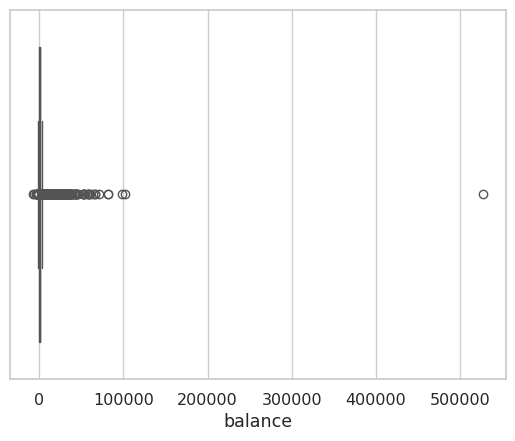

In [39]:
import seaborn as sns
sns.boxplot(x=data['balance'])

1.   **¿Existen valores extremos?** R/ Sí, se muestra claramente muchos puntos individuales por encima del bigote superior y por debajo del bigote inferior, lo que indica la presencia de numerosos valores extremos.
2.   **¿Son positivos, negativos o ambos?** R/ Son **ambos**. Hay un gran número de valores extremos positivos, como balances altos y también valores extremos negativos, que representan deudas o cuentas sobregiradas.
3.   **¿El boxplot te permite ver todos los detalles?** R/ No, un boxplot es una excelente herramienta para visualizar la distribución y detectar outliers de forma general, pero no muestra los detalles de la información.
4.   **¿Cómo afectan los outliers a la media?** R/ Los outliers, especialmente los muy extremos, afectan significativamente a la media, sesgándola. En el caso de balance, los valores extremadamente altos tiran la media hacia arriba, y los valores muy negativos la tiran hacia abajo. En este caso la media está considerablemente más alta que la mediana, lo que sugiere que hay outliers positivos que la están elevando, haciéndola menos representativa del "balance típico".
5.   **¿La mediana se ve afectada?** R/ La mediana es mucho más robusta y se ve mínimamente afectada por los outliers. Como la mediana es el valor central de un conjunto de datos ordenado, su posición no cambia drásticamente incluso si hay valores extremos en los límites del dataset.
6.   **¿Qué estadístico sería más confiable aquí?** R/ Debido a la presencia de outliers significativos, la mediana sería un estadistico de tendencia central más confiable para balance que la media.
7.   **¿Eliminarías los outliers? Justifica.** R/ No seria bueno eliminarlos sin un análisis previo muy cuidadoso. Solamente se podria hacer esto si por ejemplo son datos reales pero inusuales, o errores de entrada o datos con un impacto demasiado elevado para el modelo.
8.   **¿Podrían representar clientes reales?** R/ Si, un balance de alto podría ser un cliente de alto valor, y un balance de bajo podría ser un cliente con una deuda importante.
9.   **¿Qué riesgos existen al eliminarlos sin análisis?** R/ Eliminar outliers sin comprenderlos conlleva riesgos importantes, como la perdida de informacion valiosa, o sesgos en el analisis y los modelos ya que no representarian la realidad tan fielmente, lo que podría llevar a tomar decisiones de negocios erroneas.

# **CONCLUSIÓN**

El dataset de banco representa una gran fuente de información, pero su utilidad depende de la comprensión y el manejo de los datos.

La calidad de los datos muestran aspectos buenos y algunos malos. La presencia de valores faltantes es mínima, por lo que la mejor estrategia para su manejo es la elminiacion directa de las filas, ya que la perdida de la información sería estadisticamente insignificante y no induciría a algún sesgo que pudiera surgir con otros métodos. Por otro lado, la detección de 4 registros duplicados introduce un matiz. Para tomar la desición de eliminarlos se requiere una validación contextual. Si estos duplicados representan eventos o entidades genuinamente repetidas, su eliminación podría sesgar el análisis al subestimar la frecuencia real de ciertos fenómenos. Es crucial investigar la procedencia y la naturaleza de estos datos antes de proceder, para asegurar que no se sacrifique información válida en aras de la 'limpieza'.

En segundo lugar, las características intrínsecas de las variables presentan desafíos notables. Las variables numéricas cardinales, especialmente balance y duration, muestran una clara presencia de valores atípico. Estos extremos tienen el potencial de distorsionar severamente las medidas de tendencia central como la media, haciendo que la mediana sea una estadística mucho más robusta y representativa para describir la distribución central de estos datos.

En resumen, el dataset se encuentra en un estado que requiere de una preparación y un preprocesamiento. Los valores faltantes son manejables, pero los duplicados y los desbalances demandan estrategias para controlarlos.

# **¿Está el dataset listo para modelar? ¿Por qué?**

El dataset no está completamente listo para modelar en su estado actual, ya que existen varios puntos criticos que se deben de avordar antes de proceder con la construcción de algún modelo preditcivo.

En primer lugar, es necesario realizar un manejo apropiado para los valores faltantes, ya que a pesar de que sean pocos, es mejor que se gestionen de una manera correcta. En segundo lugar, la existencia de valores duplicados demanda una validación contextual para determinar si estas representan errores o eventos válidos. Finalmente, la presencia de los valores atípicos como "balance" y "duration" pueden distorsionar significativamente el entrenamiento de los algoritmos de machine learning.

# **Que tipos de Modelos se pueden aplicar al Dataset Bancario?**

Se pueden aplicar modelos de clasificación como la regresión logística, por su interoperabilidad, y los árboles de decisión para manejar variables categóricas y numéricas, además de capturar las interacciones no lineales. También se pueden usar modelos de agrupamiento ya que puedne ser útiles para segmentar clientes basándose en sus características.